In [34]:
import pandas as pd
from helpers import *

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from nltk import FreqDist
import operator
import numpy as np

from sklearn.model_selection import train_test_split

import pickle

## Load dataset & process it

In [35]:
df = pd.read_csv("../data/Reviews.csv")
df.columns = map(lambda x: x.lower(), df.columns)

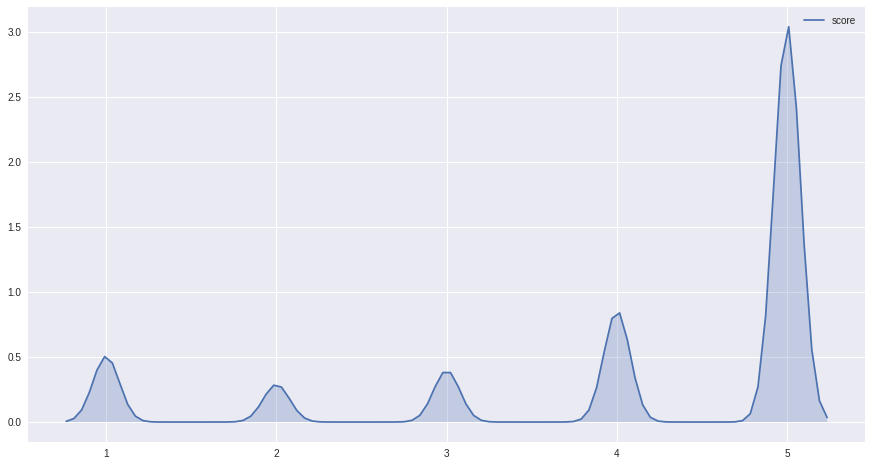

In [36]:
## score distribution
plt.figure(figsize=(15,8))
sns.kdeplot(df.score, shade=True)

In [37]:
## remove neutral reviews
df=df[df.score!=3].copy()

In [38]:
df = df[pd.notnull(df.text)].reset_index(drop=True).copy()

In [39]:
df["text"] = df["text"].apply(lambda x: cleanData(x))
df["text_length"] = df["text"].apply(lambda x: getSentenceLength(x))

## create negative dummy var
df["negative"] = df["score"].apply(lambda x: 1 if x<3 else 0)

## create numerical categories
df["cat1_num"] = df['cat1'].astype('category').cat.codes
df["cat2_num"] = df['cat2'].astype('category').cat.codes

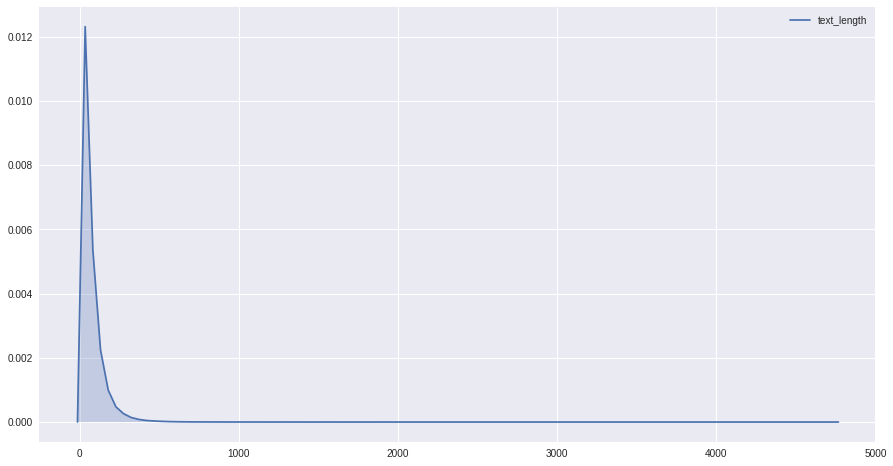

In [40]:
## review length distribution
plt.figure(figsize=(15,8))
sns.kdeplot(df.text_length, shade=True)

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1348617 entries, 0 to 1348616
Data columns (total 13 columns):
productid      1348617 non-null object
title          1348162 non-null object
userid         1348617 non-null object
helpfulness    1348617 non-null object
score          1348617 non-null float64
text           1348617 non-null object
cat1           1348617 non-null object
cat2           1348617 non-null object
cat3           1348617 non-null object
text_length    1348617 non-null int64
negative       1348617 non-null int64
cat1_num       1348617 non-null int8
cat2_num       1348617 non-null int8
dtypes: float64(1), int64(2), int8(2), object(8)
memory usage: 115.8+ MB


In [42]:
## remove reviews with length more than 100 and less than 10
df = df[df.text_length<=100].copy()
df = df[df.text_length>=10].copy()
## if length of a review is shorter than 100; fill it in with placeholer words
df["text_adj"] = df["text"].apply(lambda x: add_placeholders(x,100))

In [43]:
## create word count dictionary for all reviews
word_dist = FreqDist()
for s in df.text_adj:
    word_dist.update(s.split())

## replace rare words (occur only once)
words_to_replace = [k for k, v in word_dist.items() if v == 1]

word_lookup = {}
for word in word_dist.keys():
    if word in words_to_replace:
        word_lookup[word] = "rareword"
    else:
        word_lookup[word] = word

def replace_words(strg, words_to_replace):
    line = strg.split()
    line = [word_lookup[x] for x in line]
    result = ' '.join(line)
    return result

df["text_adj"] = df["text_adj"].apply(lambda x: replace_words(x, words_to_replace))

In [44]:
## create word count dictionary for all reviews
word_dist = FreqDist()
for s in df.text_adj:
    word_dist.update(s.split())

vocab = {}
for e,y in enumerate(word_dist.keys()):
    vocab[y]=e

In [45]:
df_sample = df.sample(n=200000, random_state=0).copy().reset_index(drop=True)

## create word count dictionary for all reviews
word_dist = FreqDist()
for s in df.text_adj:
    word_dist.update(s.split())

vocab_sample = {}
for e,y in enumerate(word_dist.keys()):
    vocab_sample[y]=e

In [46]:
## map each sentence to a vector of words:
df["sentence_vecs"] = df["text_adj"].apply(lambda x: create_sentence_vectors(x, vocab))
df_sample["sentence_vecs"] = df_sample["text_adj"].apply(lambda x: create_sentence_vectors(x, vocab_sample))

## Train / test / valid split + create pickles

In [47]:
train, test = train_test_split(df, test_size = 0.3, random_state = 0)
test, valid = train_test_split(test, test_size = 0.33, random_state = 0)
full_df = {'train': train, 'test': test, 'valid': valid, 'vocab': vocab}

In [48]:
train, test = train_test_split(df_sample, test_size = 0.3, random_state = 0)
test, valid = train_test_split(test, test_size = 0.33, random_state = 0)
sample_df = {'train': train, 'test': test, 'valid': valid, 'vocab': vocab_sample}

In [49]:
result = {'full_df': full_df, 'sample_df': sample_df}

In [50]:
with open('../data/prepared_data.pickle', 'wb') as data:
    pickle.dump(result, data)